In [40]:
#Importing the nesecarry libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.utils import to_categorical
import joblib
import matplotlib.pyplot as plt

In [2]:
#Reading the dataset
data = pd.read_csv('Darknet.csv')

In [3]:
data.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


In [4]:
import math
def log_val(val):
    if val != 0.0:
        val = val
    else:
        val = 1.0
    return int(math.log10(val))

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141530 entries, 0 to 141529
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     141530 non-null  object 
 1   Src IP                      141530 non-null  object 
 2   Src Port                    141530 non-null  int64  
 3   Dst IP                      141530 non-null  object 
 4   Dst Port                    141530 non-null  int64  
 5   Protocol                    141530 non-null  int64  
 6   Timestamp                   141530 non-null  object 
 7   Flow Duration               141530 non-null  int64  
 8   Total Fwd Packet            141530 non-null  int64  
 9   Total Bwd packets           141530 non-null  int64  
 10  Total Length of Fwd Packet  141530 non-null  int64  
 11  Total Length of Bwd Packet  141530 non-null  int64  
 12  Fwd Packet Length Max       141530 non-null  int64  
 13  Fwd Packet Len

In [6]:
data.Label.unique()

array(['Non-Tor', 'NonVPN', 'Tor', 'VPN'], dtype=object)

In [7]:
sum(data.isnull().sum())

47

In [8]:
data = data.dropna()

In [9]:
sum(data.isnull().sum())

0

In [10]:
data.drop([35848, 89028], inplace=True)

In [11]:
Y = data['Label']

In [12]:
data = data.select_dtypes(include=['float64', 'int64'])
data.columns

Index(['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN

In [13]:
data['Idle Mean']=data['Idle Mean'].apply(lambda x: log_val(x))

In [14]:
data['Idle Min']=data['Idle Min'].apply(lambda x: log_val(x))
data['Idle Max']=data['Idle Max'].apply(lambda x: log_val(x))

In [15]:
data = data[['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min','Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s','FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Idle Mean', 'Idle Min', 'Idle Max']]

In [16]:
clf = RandomForestClassifier()
rfe = RFE(estimator=clf, n_features_to_select=4, step=1)
rfe.fit(data, Y)

RFE(estimator=RandomForestClassifier(), n_features_to_select=4)

In [17]:
RFE_selected_features = data.columns[rfe.support_]
RFE_selected_features= RFE_selected_features.to_list()
RFE_selected_features

['Flow Duration',
 'Bwd Packet Length Min',
 'Fwd Header Length',
 'Fwd Packets/s']

In [18]:
data = data[['Flow Duration',
 'Bwd Packet Length Min',
 'Fwd Header Length',
 'Fwd Packets/s']]

In [19]:
data.head()

,Flow Duration,Bwd Packet Length Min,Fwd Header Length,Fwd Packets/s
0,229,0,20,4366.812227
1,407,0,20,2457.002457
2,431,0,20,2320.185615
3,359,0,20,2785.515320
4,10778451,0,11820,54.831627


In [20]:
pca = PCA()
pca.fit_transform(data)

array([[-2.08190011e+07,  5.07222419e+02, -3.84648275e+03,
        -5.27168139e+01],
       [-2.08188229e+07,  4.97036087e+02, -5.75624917e+03,
        -5.31521567e+01],
       [-2.08187989e+07,  4.96304495e+02, -5.89306188e+03,
        -5.31833383e+01],
       ...,
       [-2.03969307e+07,  4.10476216e+02, -8.16985888e+03,
        -5.34875711e+01],
       [-2.04073747e+07,  4.12197782e+02, -8.17069435e+03,
        -5.34930804e+01],
       [ 9.91708201e+07,  2.86520632e+04,  2.56014133e+03,
         9.23725479e+01]])

In [21]:
joblib.dump(pca, 'pca_transformer.joblib')

['pca_transformer.joblib']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

In [24]:
lr = Pipeline(steps = [
    ('clf', LogisticRegression())
])
rf = Pipeline(steps = [
    ('clf', RandomForestClassifier())
])

voting = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    voting = 'soft'
)

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('clf', LogisticRegression())])),
                             ('rf',
                              Pipeline(steps=[('clf',
                                               RandomForestClassifier())]))],
                 voting='soft')

In [25]:
y_pred = voting.predict(X_test)
accuracy_score(y_test, y_pred)

0.9346927236102767

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Non-Tor       0.95      0.99      0.97     18655
      NonVPN       0.90      0.82      0.86      4752
         Tor       0.63      0.34      0.44       282
         VPN       0.90      0.85      0.88      4608

    accuracy                           0.93     28297
   macro avg       0.85      0.75      0.79     28297
weighted avg       0.93      0.93      0.93     28297



In [28]:
cm = confusion_matrix(y_test, y_pred, labels=voting.classes_)

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=voting.classes_)

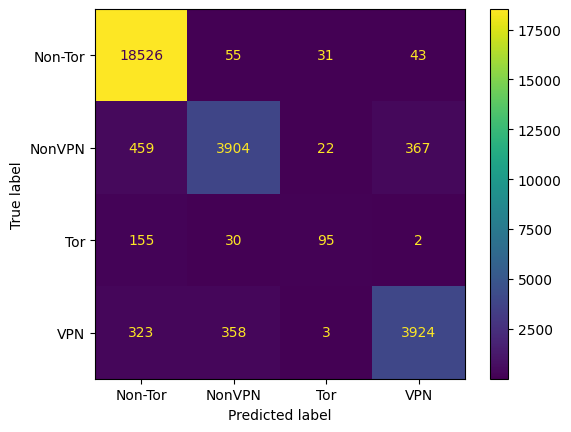

In [30]:
disp.plot()

In [31]:
le = LabelEncoder()
Y = le.fit_transform(Y)

In [32]:
Y

array([0, 0, 0, ..., 3, 3, 3])

In [33]:
joblib.dump(le, 'labelencoderfordl.joblib')

['labelencoderfordl.joblib']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

In [35]:
X_train.shape

(113184, 4)

In [36]:
model = Sequential(
    [
    Dense(16, input_shape=(4,)),
    Dense(6),
    Dense(4, activation='softmax'),
    ]
)
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
 dense_2 (Dense)             (None, 4)                 28        
                                                                 
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________


In [37]:
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs = 50)

Epoch 1/50
3537/3537 [==============================] - 5s 1ms/step - loss: 75080.2109 - accuracy: 0.5635 - val_loss: 28332.8320 - val_accuracy: 0.7010
Epoch 2/50
3537/3537 [==============================] - 5s 1ms/step - loss: 41702.2383 - accuracy: 0.5448 - val_loss: 15742.6982 - val_accuracy: 0.7042
Epoch 3/50
3537/3537 [==============================] - 4s 1ms/step - loss: 34753.0352 - accuracy: 0.5410 - val_loss: 15031.3945 - val_accuracy: 0.6155
Epoch 4/50
3537/3537 [==============================] - 4s 1ms/step - loss: 32202.8887 - accuracy: 0.5453 - val_loss: 25325.4570 - val_accuracy: 0.7179
Epoch 5/50
3537/3537 [==============================] - 4s 1ms/step - loss: 28412.5059 - accuracy: 0.5504 - val_loss: 44289.7656 - val_accuracy: 0.6037
Epoch 6/50
3537/3537 [==============================] - 4s 1ms/step - loss: 26196.1406 - accuracy: 0.5527 - val_loss: 20817.7344 - val_accuracy: 0.2817
Epoch 7/50
3537/3537 [==============================] - 4s 1ms/step - loss: 19000.1445 -

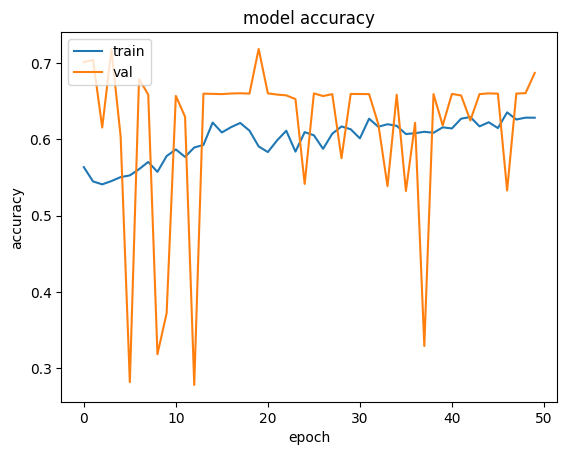

In [41]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
model2 = Sequential([
    Dense(8, input_shape=(4,)),
    Dense(16, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 64)                1088      
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 2,380
Trainable params: 2,380
Non-trainable params: 0
_________________________________________________________________


In [43]:
history2 = model2.fit(X_train, y_train,validation_data=(X_test, y_test),epochs = 50)

Epoch 1/50
3537/3537 [==============================] - 5s 1ms/step - loss: 42457.7695 - accuracy: 0.5305 - val_loss: 17955.5234 - val_accuracy: 0.6934
Epoch 2/50
3537/3537 [==============================] - 4s 1ms/step - loss: 6785.4609 - accuracy: 0.5840 - val_loss: 0.9137 - val_accuracy: 0.6952
Epoch 3/50
3537/3537 [==============================] - 4s 1ms/step - loss: 0.8433 - accuracy: 0.7175 - val_loss: 0.8107 - val_accuracy: 0.7197
Epoch 4/50
3537/3537 [==============================] - 4s 1ms/step - loss: 1.6425 - accuracy: 0.7228 - val_loss: 0.9181 - val_accuracy: 0.7204
Epoch 5/50
3537/3537 [==============================] - 4s 1ms/step - loss: 0.7926 - accuracy: 0.7226 - val_loss: 0.7880 - val_accuracy: 0.7224
Epoch 6/50
3537/3537 [==============================] - 4s 1ms/step - loss: 0.7870 - accuracy: 0.7229 - val_loss: 0.7812 - val_accuracy: 0.7237
Epoch 7/50
3537/3537 [==============================] - 4s 1ms/step - loss: 0.7803 - accuracy: 0.7260 - val_loss: 0.7780 - va

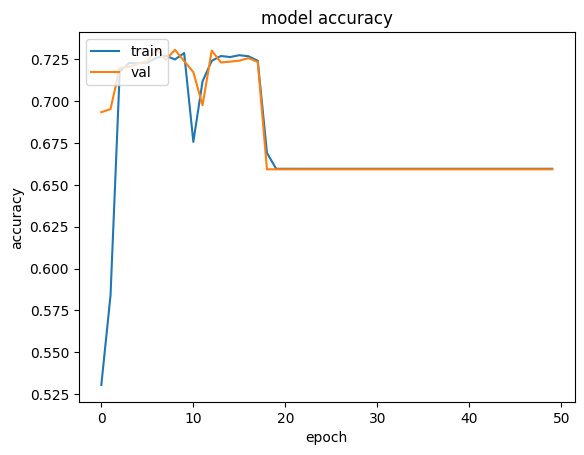

In [44]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
model2.save('dlmodel.h5')